In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import nltk
import re 
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM,GRU,Bidirectional,SimpleRNN
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam,RMSprop, SGD

from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold

# Prepaid a dataset
 This project reading a Twitter dataset, removes irrelevant tweets, preprocesses the text by converting to lowercase, removing punctuation and digits, removing stopwords, and lemmatizing the words. Finally, it maps the sentiment labels to numeric values.

In [2]:
# Load dataset and drop null values
data = pd.read_csv('twitter_training.csv',header=None).dropna()

# Remove irrelevant tweets from the dataset
data = data[data[2]!='Irrelevant']

# Remove unwanted columns from the dataset
data.drop(columns=[0,1],inplace=True)
data.head()

,2,3
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
# Define the stopwords and lemmatizer object
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and digits from text
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize text into words
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and words with length less than 2
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    # Lemmatize words
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    # Join tokens to form text again
    text = " ".join(tokens)
    return text

In [4]:
data['clean_text'] = data[3].apply(lambda x:preprocess_text(x))

In [5]:
# Map the sentiment labels to numeric values
data['sentiment'] = data[2].map({'Positive': 1, 'Neutral': 0, 'Negative': -1})
data.head()

,2,3,clean_text,sentiment
0,Positive,im getting on borderlands and i will murder yo...,im getting borderland murder,1
1,Positive,I am coming to the borders and I will kill you...,coming border kill,1
2,Positive,im getting on borderlands and i will kill you ...,im getting borderland kill,1
3,Positive,im coming on borderlands and i will murder you...,im coming borderland murder,1
4,Positive,im getting on borderlands 2 and i will murder ...,im getting borderland murder,1


# Baseline
Building a baseline model for sentiment analysis of Twitter data using the Multinomial Naive Bayes algorithm, vectorizes the preprocessed text data using TfidfVectorizer, splits it into training and testing sets, trains the Multinomial Naive Bayes classifier on the training set, evaluates the model performance using classification report, and visualizes the performance of the model using a confusion matrix. This baseline model can be used to compare the performance of more complex models for sentiment analysis of Twitter data.

In [6]:
# Get the target variable (sentiment) and predictor variable (clean_text)
baseline_y = data['sentiment'].values
baseline_X = data['clean_text'].values

# Define the vectorizer object to transform the text data into numerical features
vectorizer = TfidfVectorizer()
baseline_X = vectorizer.fit_transform(baseline_X)

# Split the data into training and testing sets
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(baseline_X, baseline_y, test_size=0.2, random_state=42)
X_train_B.shape,X_test_B.shape

((48896, 30617), (12225, 30617))

              precision    recall  f1-score   support

          -1       0.73      0.91      0.81      4427
           0       0.91      0.60      0.72      3678
           1       0.78      0.81      0.80      4120

    accuracy                           0.78     12225
   macro avg       0.81      0.77      0.78     12225
weighted avg       0.80      0.78      0.78     12225



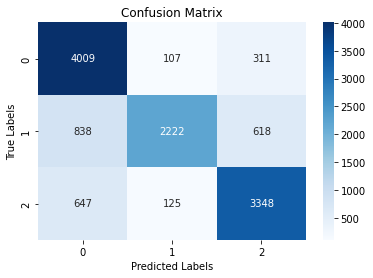

In [7]:
# Define the Naive Bayes classifier object and fit it on the training data
clf = MultinomialNB()
clf.fit(X_train_B, y_train_B)

# Make predictions on the test data using the trained model
y_pred1 = clf.predict(X_test_B)

# Generate the classification report to evaluate the performance of the model
report = classification_report(y_test_B, y_pred1)
print(report)

# Generate the confusion matrix and visualize it using seaborn
cmb = confusion_matrix(y_test_B, y_pred1)
sns.heatmap(cmb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Text representations
Preprocessing the text data by tokenizing the text and converting it into numerical sequences, which will be used as inputs to a neural network model.&nbsp;
</br>
The number of unique words in the data is also printed. The labels are converted into categorical values using one-hot encoding. These preprocessed data will be used as inputs to a neural network model for sentiment analysis.

In [8]:
# Tokenize the text data and convert it into sequences of numerical values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['clean_text'].values)
sequences = tokenizer.texts_to_sequences(data['clean_text'].values)
# Pad the sequences to have equal length
X = pad_sequences(sequences, maxlen = 40)
# Get the total number of unique words in the data
word_num = tokenizer.word_index
print('Total %s unique words.' % len(word_num))

Total 30395 unique words.


In [9]:
# Convert the labels into categorical values
y=data['sentiment']
label_encoder = LabelEncoder()
label_encoder.fit(data['sentiment'])
y = np_utils.to_categorical(label_encoder.transform(y))
y.shape

(61121, 3)

In [10]:
# Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
X_train.shape,X_test.shape

((60509, 40), (612, 40))

In [11]:
X_train.shape

(60509, 40)

In [12]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train.shape,X_val.shape

((48407, 40), (12102, 40))

## Class_weights dictionary
Calculates the class weights for each class in a multi-class classification problem, where the data is imbalanced. First, it finds the number of instances in each class from the training set using np.bincount(). Then, it calculates the weight of each class by dividing the total number of instances by the product of the number of classes and the number of instances in each class. Finally, it creates a dictionary of class indices and their corresponding weights, which can be used as the class_weight parameter in the model training process.

In [51]:
labels = np.argmax(y_train, axis=1)
class_counts = np.bincount(labels)
class_weights = class_counts.sum() / (len(class_counts) * class_counts)
class_weights= dict(zip(np.arange(len(class_weights)), class_weights))
class_weights

{0: 0.9086932852771676, 1: 1.1246718245393927, 2: 0.989736040401562}

# Ecaluation Methodology

Multiple evaluation methods to assess the performance of the model, including classification report, confusion matrix, validation loss, validation accuracy, and validation mean absolute error (MAE).

The classification report is a metric used to evaluate the performance of a classification model. It outputs metrics such as accuracy, recall, and F1 score for each class, as well as the average and weighted average of all classes. The confusion matrix is a visualization metric used to show the correct and incorrect predictions of the model for different classes, helping us understand the model's performance more intuitively.

Validation loss and accuracy are metrics used to measure the performance of the model on the validation set, which is a small dataset separated from the training data used to evaluate the model's performance on unseen data. Validation MAE is a metric used to evaluate the performance of regression models, which is the average of the absolute difference between predicted and actual values.

Additionally, the code uses K-fold cross-validation to evaluate the model's performance. K-fold cross-validation is a method used to assess the model's generalization ability, which divides the dataset into K subsets, using K-1 subsets as the training set and one subset as the validation set. Finally, the results of K folds are averaged to obtain the final evaluation result. In the code, three-fold cross-validation is used, and each subset is trained and validated.

## Validation plots function
Defines a function plot_history() to generate plots of training and validation accuracy and loss over epochs for a given Keras history object. 
<br/>
This function is used to generate plots of the training and validation accuracy and loss over epochs for the model that was trained earlier. The purpose of generating these plots is to visualize the performance of the model during training and determine if the model has overfit to the training data or not

In [13]:
# Define a function to plot the training and validation loss and accuracy over epochs
def plot_history(history):
    fig, axs = plt.subplots(2)
    # Plot training and validation accuracy over epochs
    axs[0].plot(history.history["acc"],'*-', label="accuracy")
    axs[0].plot(history.history["val_acc"],'*-', label="validation accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")
    # Plot training and validation loss over epochs
    axs[1].plot(history.history["loss"],'*-', label="loss")
    axs[1].plot(history.history["val_loss"],'*-', label="validation loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    plt.show()

### evaluate_model 
This code defines a function called evaluate_model that evaluates a given model on validation and test data. The function takes as input the model, validation data X_val and y_val, and test data X_test and y_test.

The function first evaluates the model on the validation data and prints the validation loss, validation accuracy, and validation mean absolute error (MAE). It then evaluates the model on the test data and prints the test loss, test accuracy, and test MAE.

Next, the function generates predictions on the test data using the trained model and computes the classification report and confusion matrix. The classification report contains precision, recall, F1-score, and support for each class. The confusion matrix is a table that shows the number of true positives, false positives, true negatives, and false negatives for each class.

Finally, the function generates a heatmap of the confusion matrix to visualize the model's performance. The heatmap shows the predicted labels on the x-axis and the true labels on the y-axis. The diagonal elements of the heatmap represent correct predictions, while the off-diagonal elements represent incorrect predictions. The color of each cell indicates the number of predictions for that combination of true and predicted labels.

In [14]:
# Define a function to evaluate the model's performance on validation and testing data
def evaluate_model(model, X_val, y_val, X_test, y_test):
# Evaluate the model on validation data and print the loss and accuracy
    val_loss, val_acc, val_mae = model.evaluate(X_val, y_val, batch_size=32)
    print('Validation Loss:', val_loss)
    print('Validation Accuracy:', val_acc, '\n')
# Evaluate the model on validation data and print the loss and accuracy
    test_loss, test_acc, test_mae = model.evaluate(X_test, y_test, batch_size=32)
    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_acc, '\n')
    # Generate predictions on testing data and print the classification report and confusion matrix
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    report = classification_report(y_test_labels, y_pred_labels)
    print(report)
    
 # Generate a confusion matrix plot to visualize the model's performance
    cm = confusion_matrix(y_test_labels, y_pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

### evaluate_model_with_kfold

This code defines a function evaluate_model_with_kfold that performs k-fold cross-validation on a given model. The function takes as input the training data X_train and y_train, the test data X_test and y_test, and the model to be evaluated.

The function first initializes a KFold object with the number of splits specified as n_splits (in this case, 3), and sets the shuffle and random_state parameters. It then initializes an empty list scores to store the evaluation metrics of each fold.

For each fold, the function splits the training data into training and validation sets using the indices returned by KFold. The model is then trained on the training set for the specified number of epochs, with a batch size of 128 and early stopping callback to prevent overfitting. The model is then evaluated on the validation set, and the evaluation metric (in this case, accuracy) is appended to the scores list.

After all folds have been processed, the function prints the cross-validation results (the accuracy of each fold) and the average accuracy across all folds. Finally, the model is evaluated on the test set, and the test set accuracy is printed.

This function can be useful for evaluating the performance of a model on a dataset and can help identify if the model is overfitting to the training data. By using k-fold cross-validation, we can obtain a more reliable estimate of the model's performance than if we were to evaluate it on a single train/test split.

In [15]:
def evaluate_model_with_kfold(X_train, y_train, X_test, y_test, model):
    # Define K-fold cross-validation
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    # Use K-fold cross-validation to evaluate the model
    for train_index, val_index in kfold.split(X_train):
        X_train_k, X_val_k = X_train[train_index], X_train[val_index]
        y_train_k, y_val_k = y_train[train_index], y_train[val_index]

        # Train the model
        model.fit(X_train_k, y_train_k, epochs=10, validation_data=(X_val_k, y_val_k), batch_size=128,callbacks=[checkpoint,early_stop],verbose=0)

        # Evaluate the model
        score = model.evaluate(X_val_k, y_val_k)
        scores.append(score[1])

    # Print the cross-validation results
    print("Cross-validation results:", scores)
    print("Average accuracy:", np.mean(scores))

    # Evaluate the model on the test set
    score = model.evaluate(X_test, y_test)
    print("Test set accuracy:", score[1])

### plot_validation_mae
This code defines a function plot_validation_mae that generates a plot of the validation mean absolute error (MAE) for each epoch in the training history of a deep learning model.

The function takes as input the history object returned by model.fit() method, which contains information about the loss and metrics computed during training.

The function first extracts the validation MAE values from the history object and stores them in the mae_history list. It then generates a list of epochs ranging from 1 to the length of mae_history, and plots the validation MAE against the epochs using Matplotlib's plt.plot() function.

The x-axis of the plot represents the number of epochs, and the y-axis represents the validation MAE. The plot can be used to visualize how well the model is generalizing to unseen data during training. If the validation MAE remains high while the training loss decreases, it could indicate overfitting. On the other hand, if the validation MAE decreases along with the training loss, it suggests that the model is learning to generalize well to new data

In [16]:
def plot_validation_mae(history):
    mae_history = history.history['val_mae']
    epochs = range(1, len(mae_history) + 1)
    plt.plot(epochs,mae_history)
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.show()

### smooth_curve
This function takes a list of values, called points, and applies a smoothing algorithm to it to create a new list of smoothed values, which is then returned.

The smoothing algorithm works by taking each point in the input list and computing a weighted average of that point and the previous smoothed point. The weights are determined by the factor parameter, which controls how much weight is given to the previous smoothed point versus the current input point.

The function initializes an empty list smoothed_points and then iterates over the input points. For each point, it checks whether the list of smoothed points is empty, and if so, appends the input point to the list unchanged. Otherwise, it computes the weighted average of the input point and the previous smoothed point using the factor parameter, and appends the resulting smoothed point to the list.

The result is a smoothed version of the input list, with each point being an average of the corresponding input point and the previous smoothed point, weighted more heavily towards the previous smoothed point by the factor parameter. This smoothing algorithm is often used in time series analysis and other applications where noisy data needs to be filtered to extract underlying trends.

In [17]:
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points: # an empty list is 'False'
            previous = smoothed_points[-1] # the last appended point
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Developing a model that batter then baseline but overfits 

In [18]:
# Define the number of words in the vocabulary
most_word_num = len(word_num)+3

In [19]:
# Define callbacks for early stopping and saving the best weights
checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(patience=5)

In [20]:
model_SimpleRNN = Sequential()
model_SimpleRNN.add(Embedding(most_word_num,50,input_length = X_train.shape[1]))
model_SimpleRNN.add(SimpleRNN (128))
model_SimpleRNN.add(Dense(3,activation='softmax'))
# Compile the model with the Adam optimizer and categorical cross-entropy loss
model_SimpleRNN.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['acc','mae'])
model_SimpleRNN_initial_weights = model_SimpleRNN.get_weights()
# Print the summary of the model structure
print(model_SimpleRNN.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 50)            1519900   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               22912     
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,543,199
Trainable params: 1,543,199
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
model_SimpleRNN.set_weights(model_SimpleRNN_initial_weights)

model_SimpleRNN_history = model_SimpleRNN.fit(X_train,y_train,epochs=30,validation_data=(X_val, y_val), batch_size = 256,callbacks=[checkpoint,early_stop])

Epoch 1/30
190/190 [==============================] - 11s 50ms/step - loss: 0.8325 - acc: 0.6196 - mae: 0.3421 - val_loss: 0.5450 - val_acc: 0.7870 - val_mae: 0.2256
Epoch 2/30
190/190 [==============================] - 10s 53ms/step - loss: 0.3051 - acc: 0.8874 - mae: 0.1275 - val_loss: 0.3438 - val_acc: 0.8647 - val_mae: 0.1306
Epoch 3/30
190/190 [==============================] - 11s 57ms/step - loss: 0.1519 - acc: 0.9427 - mae: 0.0636 - val_loss: 0.3668 - val_acc: 0.8620 - val_mae: 0.1206
Epoch 4/30
190/190 [==============================] - 11s 58ms/step - loss: 0.1050 - acc: 0.9584 - mae: 0.0433 - val_loss: 0.3542 - val_acc: 0.8784 - val_mae: 0.0985
Epoch 5/30
190/190 [==============================] - 12s 61ms/step - loss: 0.0850 - acc: 0.9656 - mae: 0.0345 - val_loss: 0.3963 - val_acc: 0.8731 - val_mae: 0.0991
Epoch 6/30
190/190 [==============================] - 12s 64ms/step - loss: 0.0740 - acc: 0.9681 - mae: 0.0296 - val_loss: 0.4140 - val_acc: 0.8750 - val_mae: 0.0942
Epoc

379/379 [==============================] - 1s 3ms/step - loss: 0.4170 - acc: 0.8760 - mae: 0.0925
Validation Loss: 0.41700509190559387
Validation Accuracy: 0.8759709000587463 

20/20 [==============================] - 0s 3ms/step - loss: 0.4395 - acc: 0.8807 - mae: 0.0903
Test Loss: 0.4395208954811096
Test Accuracy: 0.8807189464569092 

20/20 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       220
           1       0.88      0.87      0.88       193
           2       0.86      0.89      0.87       199

    accuracy                           0.88       612
   macro avg       0.88      0.88      0.88       612
weighted avg       0.88      0.88      0.88       612



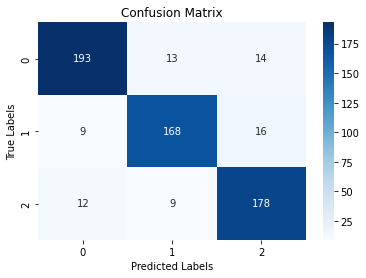

In [23]:
evaluate_model(model_SimpleRNN, X_val, y_val, X_test, y_test)

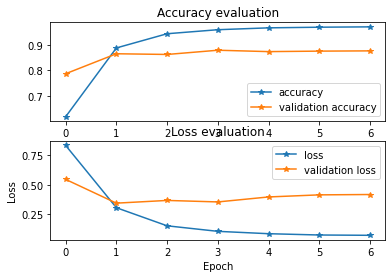

In [22]:
plot_history(model_SimpleRNN_history)

### Observation and Explanation for above curve: 
During the training process, the training loss keeps decreasing while the validation loss first decreases, reaches a minimum, and then starts to increase again.
<br/><br/>
This is a common phenomenon called overfitting, where the model is trained too well on the training data and starts to learn the noise in the data. As a result, the model's performance starts to deteriorate on unseen validation data, and the validation loss starts to increase. It means that the model has started to memorize the training data instead of learning the underlying patterns, and it fails to generalize well on new data.

# RNN Model
Builds a RNN model for sentiment analysis with an Embedding layer, GRU layer, and several Dense layers with different activation functions and regularization. The Adam optimizer is used to minimize the categorical cross-entropy loss during training. The training process is saved with callbacks to save the weights with best validation loss and stop early if the validation loss does not improve. The RNN model is trained on the preprocessed training data, and the validation data is used to evaluate the model's performance during training. The history of the training process is saved for further analysis.

In [24]:
# Define the structure of the neural network model
model_RNN = Sequential()
model_RNN.add(Embedding(most_word_num,50,input_length = X_train.shape[1]))
model_RNN.add(GRU(100, dropout = 0.2, recurrent_dropout = 0.2, kernel_regularizer=regularizers.l2(0.02)))
model_RNN.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.02)))
model_RNN.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.02)))
model_RNN.add(Dense(3,activation='softmax'))
# Compile the model with the Adam optimizer and categorical cross-entropy loss
model_RNN.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['acc','mae'])
model_RNN_initial_weights = model_RNN.get_weights()
# Print the summary of the model structure
print(model_RNN.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 50)            1519900   
                                                                 
 gru (GRU)                   (None, 100)               45600     
                                                                 
 dense_1 (Dense)             (None, 64)                6464      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1,574,143
Trainable params: 1,574,143
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
model_RNN.set_weights(model_RNN_initial_weights)
# Train the model on the preprocessed training data and validate it using the validation data
model_RNN_history = model_RNN.fit(X_train,y_train,epochs=20,validation_data=(X_val, y_val), batch_size = 128,callbacks=[checkpoint,early_stop])

Epoch 1/20
379/379 [==============================] - 44s 110ms/step - loss: 2.1744 - acc: 0.4631 - mae: 0.4138 - val_loss: 1.0489 - val_acc: 0.5836 - val_mae: 0.3559
Epoch 2/20
379/379 [==============================] - 39s 104ms/step - loss: 0.8860 - acc: 0.6383 - mae: 0.3190 - val_loss: 0.8154 - val_acc: 0.6748 - val_mae: 0.3074
Epoch 3/20
379/379 [==============================] - 39s 104ms/step - loss: 0.7397 - acc: 0.7233 - mae: 0.2688 - val_loss: 0.7535 - val_acc: 0.7130 - val_mae: 0.2731
Epoch 4/20
379/379 [==============================] - 38s 100ms/step - loss: 0.6649 - acc: 0.7678 - mae: 0.2370 - val_loss: 0.7116 - val_acc: 0.7381 - val_mae: 0.2490
Epoch 5/20
379/379 [==============================] - 38s 100ms/step - loss: 0.6128 - acc: 0.7937 - mae: 0.2143 - val_loss: 0.6920 - val_acc: 0.7525 - val_mae: 0.2344
Epoch 6/20
379/379 [==============================] - 38s 100ms/step - loss: 0.5752 - acc: 0.8166 - mae: 0.1966 - val_loss: 0.6810 - val_acc: 0.7600 - val_mae: 0.226

379/379 [==============================] - 3s 7ms/step - loss: 0.4852 - acc: 0.8534 - mae: 0.1207
Validation Loss: 0.48518919944763184
Validation Accuracy: 0.8534126877784729 

20/20 [==============================] - 0s 7ms/step - loss: 0.5210 - acc: 0.8431 - mae: 0.1215
Test Loss: 0.5209800601005554
Test Accuracy: 0.843137264251709 

20/20 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.92      0.83      0.88       220
           1       0.77      0.87      0.82       193
           2       0.84      0.83      0.84       199

    accuracy                           0.84       612
   macro avg       0.85      0.84      0.84       612
weighted avg       0.85      0.84      0.84       612



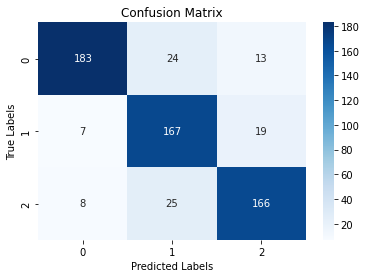

In [26]:
evaluate_model(model_RNN, X_val, y_val, X_test, y_test)

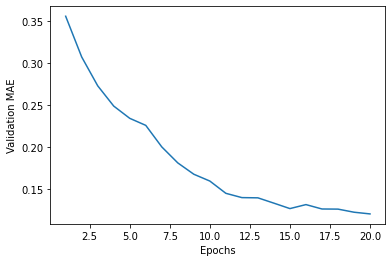

In [27]:
plot_validation_mae(model_RNN_history)

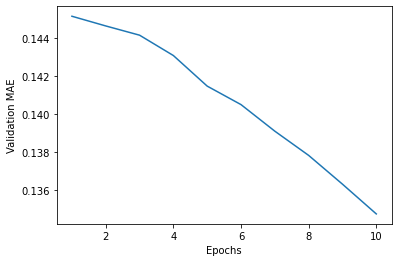

In [28]:
smooth_mae_history = smooth_curve(model_RNN_history.history['val_mae'][10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

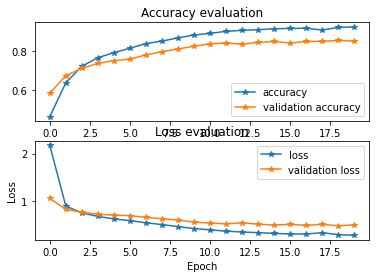

In [29]:
plot_history(model_RNN_history)

In [30]:
evaluate_model_with_kfold(X_train, y_train, X_test, y_test, model_RNN)

505/505 [==============================] - 4s 7ms/step - loss: 0.2297 - acc: 0.9284 - mae: 0.0672
Cross-validation results: [0.9229053258895874, 0.9294744729995728, 0.9283545017242432]
Average accuracy: 0.9269114335378011
20/20 [==============================] - 0s 7ms/step - loss: 0.5120 - acc: 0.8562 - mae: 0.1148
Test set accuracy: 0.8562091588973999


# LSTM Model

Defines an LSTM model with an embedding layer and multiple dense layers, compiles it with an optimizer, loss function, and evaluation metrics, trains it, generates plots of its training and validation performance over epochs, and evaluates its performance on the validation and testing data. The purpose of training and evaluating the LSTM model is to determine if it can outperform the previous RNN model on the sentiment classification task. The classification report and confusion matrix provide additional metrics for evaluating the model's performance on different classes of sentiment.

In [31]:
# Define an LSTM model architecture
model_LSTM = Sequential()
model_LSTM.add(Embedding(int(most_word_num),50,input_length = X_train.shape[1]))
model_LSTM.add(LSTM(100, dropout = 0.2, recurrent_dropout = 0.2,kernel_regularizer=regularizers.l2(0.02)))
model_LSTM.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.02)))
model_LSTM.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.02)))
model_LSTM.add(Dense(3,activation='softmax'))
# Compile the LSTM model with an optimizer, loss function, and evaluation metrics

model_LSTM.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['acc', 'mae'])
# Print a summary of the LSTM model architecture
model_LSTM_initial_weights = model_LSTM.get_weights()
print(model_LSTM.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 50)            1519900   
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense_4 (Dense)             (None, 64)                6464      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1,588,943
Trainable params: 1,588,943
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
model_LSTM.set_weights(model_LSTM_initial_weights)
# Train the LSTM model and store the history of training in a variable
model_LSTM_history = model_LSTM.fit(X_train,y_train,epochs=20,validation_data=(X_val, y_val), batch_size = 128,callbacks=[checkpoint,early_stop])

Epoch 1/20
379/379 [==============================] - 50s 124ms/step - loss: 2.1419 - acc: 0.4588 - mae: 0.4181 - val_loss: 1.0599 - val_acc: 0.5935 - val_mae: 0.3726
Epoch 2/20
379/379 [==============================] - 47s 124ms/step - loss: 0.8496 - acc: 0.6893 - mae: 0.2963 - val_loss: 0.7472 - val_acc: 0.7384 - val_mae: 0.2590
Epoch 3/20
379/379 [==============================] - 45s 119ms/step - loss: 0.6389 - acc: 0.7933 - mae: 0.2117 - val_loss: 0.6652 - val_acc: 0.7728 - val_mae: 0.2275
Epoch 4/20
379/379 [==============================] - 44s 117ms/step - loss: 0.5345 - acc: 0.8370 - mae: 0.1694 - val_loss: 0.6027 - val_acc: 0.8105 - val_mae: 0.2031
Epoch 5/20
379/379 [==============================] - 44s 116ms/step - loss: 0.4723 - acc: 0.8648 - mae: 0.1450 - val_loss: 0.5719 - val_acc: 0.8216 - val_mae: 0.1613
Epoch 6/20
379/379 [==============================] - 44s 117ms/step - loss: 0.4274 - acc: 0.8816 - mae: 0.1278 - val_loss: 0.5418 - val_acc: 0.8285 - val_mae: 0.164

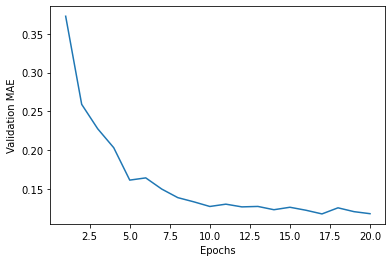

In [33]:
plot_validation_mae(model_LSTM_history)

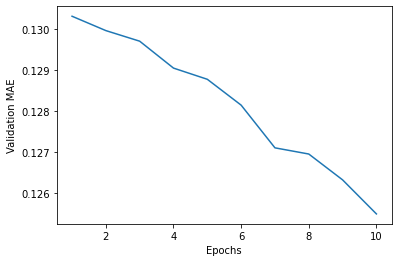

In [34]:
smooth_mae_history = smooth_curve(model_LSTM_history.history['val_mae'][10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

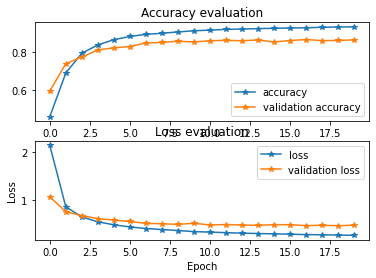

In [35]:
# Generate plots of the LSTM model's training and validation performance over epochs
plot_history(model_LSTM_history)

379/379 [==============================] - 21s 56ms/step - loss: 0.4884 - acc: 0.8633 - mae: 0.1081
Validation Loss: 0.48835423588752747
Validation Accuracy: 0.8633283972740173 

20/20 [==============================] - 1s 57ms/step - loss: 0.5413 - acc: 0.8595 - mae: 0.1104
Test Loss: 0.541276216506958
Test Accuracy: 0.8594771027565002 

20/20 [==============================] - 1s 54ms/step
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       220
           1       0.87      0.84      0.85       193
           2       0.85      0.84      0.85       199

    accuracy                           0.86       612
   macro avg       0.86      0.86      0.86       612
weighted avg       0.86      0.86      0.86       612



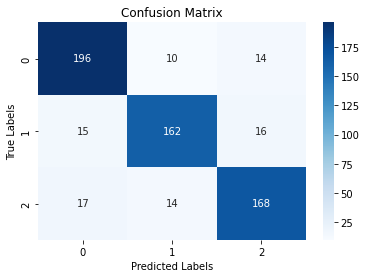

In [78]:
# Evaluate the LSTM model's performance on the validation and testing data
evaluate_model(model_LSTM, X_val, y_val, X_test, y_test)

In [37]:
evaluate_model_with_kfold(X_train, y_train, X_test, y_test, model_LSTM)

505/505 [==============================] - 5s 9ms/step - loss: 0.2230 - acc: 0.9298 - mae: 0.0643
Cross-validation results: [0.9157164096832275, 0.9224095344543457, 0.9297800064086914]
Average accuracy: 0.9226353168487549
20/20 [==============================] - 0s 9ms/step - loss: 0.5413 - acc: 0.8595 - mae: 0.1104
Test set accuracy: 0.8594771027565002


# Two-layer RNN+LSTM model

Defines a two-layer RNN+LSTM model with an embedding layer and multiple dense layers, compiles it with an optimizer, loss function, and evaluation metrics, trains it, generates plots of its training and validation performance over epochs, and evaluates its performance on the validation and testing data. The purpose of training and evaluating the two-layer RNN+LSTM model is to determine if it can outperform the previous RNN and LSTM models on the sentiment classification task. The classification report and confusion matrix provide additional metrics for evaluating the model's performance on different classes of sentiment.

In [38]:
# Define a two-layer RNN+LSTM model architecture
model_RNN_LSTM = Sequential()
model_RNN_LSTM.add(Embedding(int(most_word_num),50,input_length = X_train.shape[1]))
model_RNN_LSTM.add(Bidirectional(GRU(units=100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model_RNN_LSTM.add(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2,kernel_regularizer=regularizers.l2(0.02)))
model_RNN_LSTM.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.02)))
model_RNN_LSTM.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.02)))
model_RNN_LSTM.add(Dense(3,activation='softmax'))
# Compile the two-layer RNN+LSTM model with an optimizer, loss function, and evaluation metrics
model_RNN_LSTM.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['acc', 'mae'])
model_RNN_LSTM_initial_weights = model_RNN_LSTM.get_weights()
# Print a summary of the two-layer RNN+LSTM model architecture

print(model_RNN_LSTM.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 40, 50)            1519900   
                                                                 
 bidirectional (Bidirectiona  (None, 40, 200)          91200     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 64)                67840     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 3)                 99        
                                                      

In [39]:
model_RNN_LSTM_initial_weights = model_RNN_LSTM.get_weights()
# Train the two-layer RNN+LSTM model and store the history of training in a variable
model_RNN_LSTM_history = model_RNN_LSTM.fit(X_train,y_train,epochs=20,validation_data=(X_val, y_val), batch_size = 128,callbacks=[checkpoint,early_stop])

Epoch 1/20
379/379 [==============================] - 129s 325ms/step - loss: 2.5348 - acc: 0.5393 - mae: 0.3815 - val_loss: 0.9642 - val_acc: 0.6922 - val_mae: 0.3076
Epoch 2/20
379/379 [==============================] - 121s 320ms/step - loss: 0.7384 - acc: 0.7590 - mae: 0.2426 - val_loss: 0.6595 - val_acc: 0.7770 - val_mae: 0.2200
Epoch 3/20
379/379 [==============================] - 123s 324ms/step - loss: 0.4997 - acc: 0.8451 - mae: 0.1614 - val_loss: 0.5262 - val_acc: 0.8251 - val_mae: 0.1621
Epoch 4/20
379/379 [==============================] - 124s 326ms/step - loss: 0.3905 - acc: 0.8810 - mae: 0.1218 - val_loss: 0.5008 - val_acc: 0.8383 - val_mae: 0.1402
Epoch 5/20
379/379 [==============================] - 125s 331ms/step - loss: 0.3370 - acc: 0.8990 - mae: 0.1036 - val_loss: 0.4552 - val_acc: 0.8507 - val_mae: 0.1273
Epoch 6/20
379/379 [==============================] - 125s 329ms/step - loss: 0.2971 - acc: 0.9108 - mae: 0.0905 - val_loss: 0.4473 - val_acc: 0.8547 - val_mae:

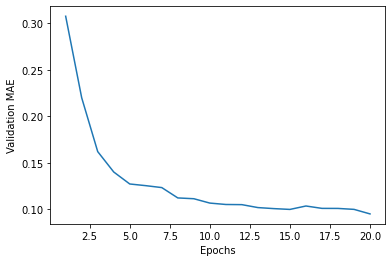

In [40]:
plot_validation_mae(model_RNN_LSTM_history)

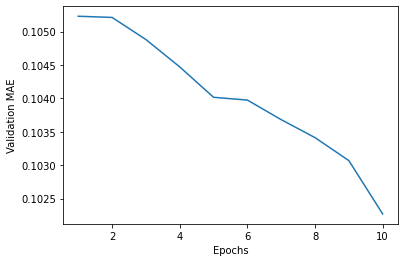

In [41]:
smooth_mae_history = smooth_curve(model_RNN_LSTM_history.history['val_mae'][10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

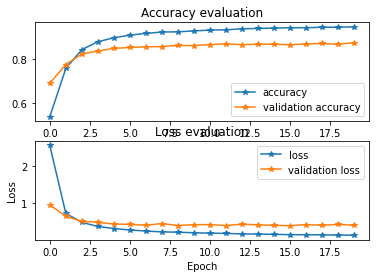

In [42]:
# Generate plots of the two-layer RNN+LSTM model's training and validation performance over epochs
plot_history(model_RNN_LSTM_history)

379/379 [==============================] - 10s 26ms/step - loss: 0.4216 - acc: 0.8770 - mae: 0.0951
Validation Loss: 0.4215690493583679
Validation Accuracy: 0.8769624829292297 

20/20 [==============================] - 1s 25ms/step - loss: 0.3823 - acc: 0.8824 - mae: 0.0870
Test Loss: 0.3822503387928009
Test Accuracy: 0.8823529481887817 

20/20 [==============================] - 1s 22ms/step
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       220
           1       0.93      0.87      0.90       193
           2       0.84      0.89      0.86       199

    accuracy                           0.88       612
   macro avg       0.88      0.88      0.88       612
weighted avg       0.88      0.88      0.88       612



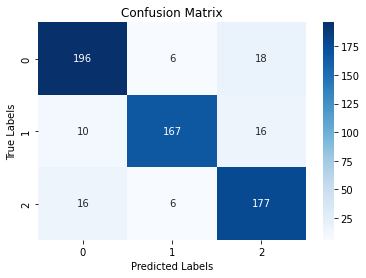

In [43]:
# Evaluate the two-layer RNN+LSTM model's performance on the validation and testing data
evaluate_model(model_RNN_LSTM, X_val, y_val, X_test, y_test)

In [44]:
evaluate_model_with_kfold(X_train, y_train,X_test, y_test, model_RNN_LSTM)

505/505 [==============================] - 17s 34ms/step - loss: 0.1356 - acc: 0.9509 - mae: 0.0433
Cross-validation results: [0.9427367448806763, 0.9434804320335388, 0.9508521556854248]
Average accuracy: 0.9456897775332133
20/20 [==============================] - 1s 34ms/step - loss: 0.3466 - acc: 0.8905 - mae: 0.0836
Test set accuracy: 0.8905228972434998


# Regularizing best model and tuning hyperparameters

In [45]:
from sklearn.model_selection import StratifiedKFold
import keras
import tensorflow
import itertools
import matplotlib.pyplot as plt

### cross_validation
This code defines a function called cross_validation that performs k-fold cross-validation on a given model. It takes in the model, data, class weights, hyperparameters, number of folds, number of epochs, and callbacks as inputs. The function uses KFold from scikit-learn to split the data into k partitions and then trains and evaluates the model on each partition. The function returns the mean of the evaluation metrics across all the folds.

In [50]:
def cross_validation(model, X, y, class_weight, params, kfolds, epochs, callbacks, seed=0):
    evaluations = []
    for train, validate in kfolds.split(X, y.argmax(axis=1)):
        model_copy = keras.models.clone_model(model)      
        model_copy.compile(optimizer=Adam(learning_rate=params['learning_rate']), 
                      loss="categorical_crossentropy", 
                      metrics=['categorical_accuracy', 'Precision', 'Recall','AUC'])

        history = model_copy.fit(X[train], y[train],
                                 class_weight=class_weight,
                                 batch_size=128, 
                                 epochs=epochs, 
                                 validation_data=(X[validate], y[validate]),
                                 callbacks=callbacks,
                                 verbose=1)

        evaluation = model_copy.evaluate(X_val, y_val, verbose=0)[1:]
        evaluations.append(evaluation)

    return np.mean(evaluations, axis=0)


### grid_search_cv
This code defines a function grid_search_cv that performs a grid search on a given model using cross-validation. The function takes as input the model, the data X and y, class weights for balancing class distribution, a search space of hyperparameters to be tuned, the number of folds for cross-validation cv, the number of epochs, and callbacks.

The function first creates a k-fold cross-validation object kfolds using StratifiedKFold from scikit-learn. It then initializes an empty dictionary stats to store the evaluation metrics of each combination of hyperparameters. For each combination of hyperparameters, it calls the cross_validation function to perform k-fold cross-validation with the given hyperparameters, and stores the evaluation metrics in the stats dictionary.

Finally, the function returns the stats dictionary with the mean of the evaluation metrics across all the folds for each combination of hyperparameters.

In [52]:
def grid_search_cv(model,X, y,
                   class_weight,
                   search_space, cv,
                   epochs, callbacks=[], seed=0) :
    
    keys, values = zip(*search_space.items())
    kfolds = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
    stats = {}
    for params in [dict(zip(keys, v)) for v in itertools.product(*values)] :
        
        scores = cross_validation(model,X, y, class_weight,
                                  params, kfolds, epochs,
                                  callbacks, seed)
        
        stats[str(params)] = scores
    
    return stats

In [53]:
params = {
    'learning_rate': [0.0001, 0.0005],
}


In [54]:
stats = grid_search_cv(model_RNN_LSTM,X_train, y_train,
                       class_weight=class_weights,
                       search_space=params, cv=3, epochs=30, 
                       callbacks=[checkpoint,early_stop], seed=42)

Epoch 1/30
253/253 [==============================] - 103s 385ms/step - loss: 6.2285 - categorical_accuracy: 0.3901 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5712 - val_loss: 4.9148 - val_categorical_accuracy: 0.4480 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6333
Epoch 2/30
253/253 [==============================] - 106s 420ms/step - loss: 3.9065 - categorical_accuracy: 0.5665 - precision: 0.6952 - recall: 0.2926 - auc: 0.7448 - val_loss: 3.0685 - val_categorical_accuracy: 0.6322 - val_precision: 0.7260 - val_recall: 0.4967 - val_auc: 0.8143
Epoch 3/30
253/253 [==============================] - 105s 417ms/step - loss: 2.5198 - categorical_accuracy: 0.6869 - precision: 0.7369 - recall: 0.6136 - auc: 0.8498 - val_loss: 2.1092 - val_categorical_accuracy: 0.6831 - val_precision: 0.7060 - val_recall: 0.6439 - val_auc: 0.8498
Epoch 4/30
253/253 [==============================] - 106s 420ms/step - loss: 1.7547 - categorical_accuracy: 0.7386 - precision: 0.7

Epoch 1/30
253/253 [==============================] - 124s 463ms/step - loss: 6.1938 - categorical_accuracy: 0.3765 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5608 - val_loss: 4.8866 - val_categorical_accuracy: 0.3914 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6021
Epoch 2/30
253/253 [==============================] - 118s 468ms/step - loss: 3.9126 - categorical_accuracy: 0.4848 - precision: 0.6979 - recall: 0.1439 - auc: 0.7029 - val_loss: 3.1001 - val_categorical_accuracy: 0.5550 - val_precision: 0.6803 - val_recall: 0.2548 - val_auc: 0.7670
Epoch 3/30
253/253 [==============================] - 117s 464ms/step - loss: 2.5574 - categorical_accuracy: 0.5911 - precision: 0.7299 - recall: 0.3130 - auc: 0.7988 - val_loss: 2.1556 - val_categorical_accuracy: 0.5973 - val_precision: 0.6584 - val_recall: 0.5034 - val_auc: 0.7998
Epoch 4/30
253/253 [==============================] - 118s 466ms/step - loss: 1.8124 - categorical_accuracy: 0.6290 - precision: 0.7

Epoch 30/30
253/253 [==============================] - 123s 485ms/step - loss: 0.2959 - categorical_accuracy: 0.9129 - precision: 0.9414 - recall: 0.8909 - auc: 0.9834 - val_loss: 0.6669 - val_categorical_accuracy: 0.7973 - val_precision: 0.8208 - val_recall: 0.7791 - val_auc: 0.9180
Epoch 1/30
253/253 [==============================] - 135s 508ms/step - loss: 6.2140 - categorical_accuracy: 0.3764 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5704 - val_loss: 4.9066 - val_categorical_accuracy: 0.3859 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5944
Epoch 2/30
253/253 [==============================] - 129s 511ms/step - loss: 3.9485 - categorical_accuracy: 0.4721 - precision: 0.6053 - recall: 0.1741 - auc: 0.6858 - val_loss: 3.1202 - val_categorical_accuracy: 0.5367 - val_precision: 0.6128 - val_recall: 0.3776 - val_auc: 0.7529
Epoch 3/30
253/253 [==============================] - 130s 515ms/step - loss: 2.5651 - categorical_accuracy: 0.5726 - precision: 0.

Epoch 7/30
253/253 [==============================] - 140s 554ms/step - loss: 0.2790 - categorical_accuracy: 0.9182 - precision: 0.9464 - recall: 0.8959 - auc: 0.9848 - val_loss: 0.5598 - val_categorical_accuracy: 0.8288 - val_precision: 0.8662 - val_recall: 0.8001 - val_auc: 0.9343
Epoch 8/30
253/253 [==============================] - 139s 551ms/step - loss: 0.2580 - categorical_accuracy: 0.9237 - precision: 0.9515 - recall: 0.9038 - auc: 0.9870 - val_loss: 0.5354 - val_categorical_accuracy: 0.8343 - val_precision: 0.8656 - val_recall: 0.8109 - val_auc: 0.9442
Epoch 9/30
253/253 [==============================] - 138s 547ms/step - loss: 0.2425 - categorical_accuracy: 0.9281 - precision: 0.9533 - recall: 0.9093 - auc: 0.9886 - val_loss: 0.5235 - val_categorical_accuracy: 0.8359 - val_precision: 0.8754 - val_recall: 0.8028 - val_auc: 0.9460
Epoch 10/30
253/253 [==============================] - 138s 546ms/step - loss: 0.2244 - categorical_accuracy: 0.9344 - precision: 0.9580 - recall: 0

Epoch 15/30
253/253 [==============================] - 180s 712ms/step - loss: 0.2102 - categorical_accuracy: 0.9371 - precision: 0.9591 - recall: 0.9224 - auc: 0.9911 - val_loss: 0.5508 - val_categorical_accuracy: 0.8350 - val_precision: 0.8450 - val_recall: 0.8253 - val_auc: 0.9389
Epoch 16/30
253/253 [==============================] - 170s 671ms/step - loss: 0.2023 - categorical_accuracy: 0.9407 - precision: 0.9606 - recall: 0.9257 - auc: 0.9918 - val_loss: 0.6238 - val_categorical_accuracy: 0.8278 - val_precision: 0.8380 - val_recall: 0.8199 - val_auc: 0.9293
Epoch 1/30
253/253 [==============================] - 150s 567ms/step - loss: 3.2109 - categorical_accuracy: 0.4701 - precision: 0.6672 - recall: 0.1566 - auc: 0.6812 - val_loss: 1.2946 - val_categorical_accuracy: 0.5927 - val_precision: 0.6403 - val_recall: 0.5218 - val_auc: 0.7902
Epoch 2/30
253/253 [==============================] - 143s 564ms/step - loss: 0.9663 - categorical_accuracy: 0.6470 - precision: 0.7252 - recall: 

Output stats is a dictionary containing the evaluation metrics for all combinations of hyperparameters tried during the grid search. It can be used to compare the performance of different hyperparameter combinations and select the best set of hyperparameters for the neural network model.

In [55]:
stats

{"{'learning_rate': 0.0001}": array([0.79920675, 0.8320291 , 0.76480474, 0.91807095]),
 "{'learning_rate': 0.0005}": array([0.83650084, 0.8608285 , 0.81884537, 0.93997282])}

In [56]:
import json

In [61]:
def dict_to_dataframe(stats):
    entries = []
    for key, value in stats.items():
        params_dict = json.loads(key.replace("'", "\""))
        entry = params_dict.copy()
        for i, metric_name in enumerate(['accuracy', 'precision', 'recall', 'auc']):
            entry[metric_name] = value[i]
        entries.append(entry)

    df = pd.DataFrame(entries)
    columns_order = ['auc','learning_rate', 'accuracy', 'precision', 'recall']
    df = df[columns_order]
    return df

In [62]:
kfold_stats = dict_to_dataframe(stats)

kfold_stats.sort_values(by=['auc'], ascending=False).head(10)

,auc,learning_rate,accuracy,precision,recall
1,0.939973,0.0005,0.836501,0.860828,0.818845
0,0.918071,0.0001,0.799207,0.832029,0.764805


### Best hyperparameters
stores the hyperparameters that achieved the best performance during the hyperparameter tuning process

In [63]:
best_params = {
    'learning_rate':0.0005,
}

# Building the best model using the best hyperparameters

In [79]:
best_model = keras.models.clone_model(model_RNN_LSTM)

# Modify the parameters  
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), 
                   loss="categorical_crossentropy", 
                   metrics=['acc', 'mae', 'Precision', 'Recall', 'AUC'])
best_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 40, 50)            1519900   
                                                                 
 bidirectional (Bidirectiona  (None, 40, 200)          91200     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 64)                67840     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 3)                 99        
                                                      

In [80]:
best_model_history = best_model.fit(X_train, y_train,
                         class_weight=class_weights,
                         batch_size=128, epochs=30, 
                         validation_data=(X_val, y_val),
                         callbacks=[checkpoint,early_stop],
                         verbose=1)

Epoch 1/30
379/379 [==============================] - 244s 625ms/step - loss: 2.5667 - acc: 0.5105 - mae: 0.3928 - precision: 0.6504 - recall: 0.2529 - auc: 0.7104 - val_loss: 0.9948 - val_acc: 0.6676 - val_mae: 0.3363 - val_precision: 0.7502 - val_recall: 0.4740 - val_auc: 0.8296
Epoch 2/30
379/379 [==============================] - 250s 660ms/step - loss: 0.7647 - acc: 0.7419 - mae: 0.2603 - precision: 0.7698 - recall: 0.6950 - auc: 0.8818 - val_loss: 0.7392 - val_acc: 0.7011 - val_mae: 0.2672 - val_precision: 0.8316 - val_recall: 0.6114 - val_auc: 0.8790
Epoch 3/30
379/379 [==============================] - 277s 731ms/step - loss: 0.5661 - acc: 0.8189 - mae: 0.1888 - precision: 0.8567 - recall: 0.7796 - auc: 0.9340 - val_loss: 0.5671 - val_acc: 0.8129 - val_mae: 0.1848 - val_precision: 0.8377 - val_recall: 0.7838 - val_auc: 0.9330
Epoch 4/30
379/379 [==============================] - 239s 630ms/step - loss: 0.4197 - acc: 0.8736 - mae: 0.1329 - precision: 0.9015 - recall: 0.8494 - au

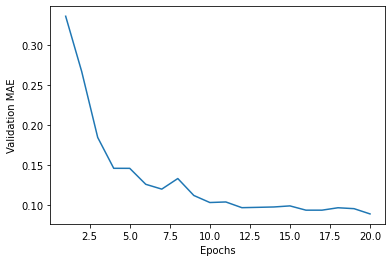

In [81]:
plot_validation_mae(best_model_history)

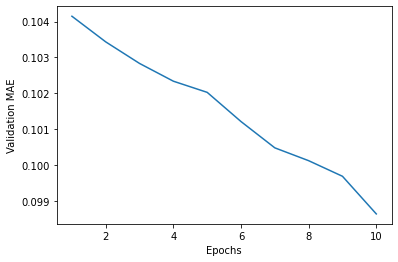

In [82]:
smooth_mae_history = smooth_curve(best_model_history.history['val_mae'][10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

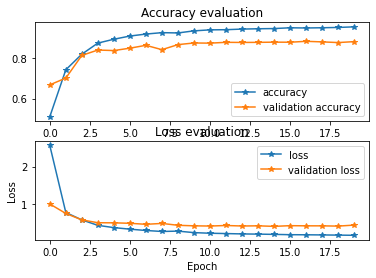

In [83]:
plot_history(best_model_history)

In [87]:
# Define a function to evaluate the model's performance on validation and testing data
def final_evaluate_model(model, X_val, y_val, X_test, y_test):
# Evaluate the model on validation data and print the loss and accuracy
    val_loss, val_acc, val_mae,val_precision,val_recall,val_auc  = model.evaluate(X_val, y_val, batch_size=32)
    print('Validation Loss:', val_loss)
    print('Validation Accuracy:', val_acc, '\n')
# Evaluate the model on validation data and print the loss and accuracy
    test_loss, test_acc, test_mae,test_precision,test_recall,test_auc = model.evaluate(X_test, y_test, batch_size=32)
    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_acc, '\n')
    # Generate predictions on testing data and print the classification report and confusion matrix
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    report = classification_report(y_test_labels, y_pred_labels)
    print(report)
    
 # Generate a confusion matrix plot to visualize the model's performance
    cm = confusion_matrix(y_test_labels, y_pred_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

379/379 [==============================] - 54s 143ms/step - loss: 0.4424 - acc: 0.8782 - mae: 0.0895 - precision: 0.9023 - recall: 0.8647 - auc: 0.9618
Validation Loss: 0.4423670768737793
Validation Accuracy: 0.878201961517334 

20/20 [==============================] - 3s 142ms/step - loss: 0.4022 - acc: 0.8824 - mae: 0.0861 - precision: 0.9078 - recall: 0.8693 - auc: 0.9661
Test Loss: 0.4021594524383545
Test Accuracy: 0.8823529481887817 

20/20 [==============================] - 4s 139ms/step
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       220
           1       0.90      0.87      0.89       193
           2       0.83      0.91      0.87       199

    accuracy                           0.88       612
   macro avg       0.88      0.88      0.88       612
weighted avg       0.89      0.88      0.88       612



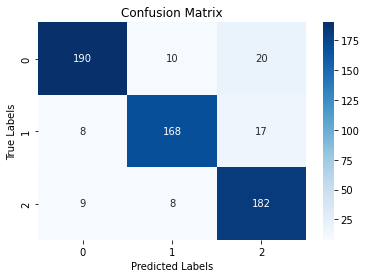

In [88]:
final_evaluate_model(best_model, X_val, y_val, X_test, y_test)

In [89]:
evaluate_model_with_kfold(X_train, y_train,X_test, y_test, best_model)

505/505 [==============================] - 71s 140ms/step - loss: 0.1156 - acc: 0.9597 - mae: 0.0357 - precision: 0.9813 - recall: 0.9461 - auc: 0.9970
Cross-validation results: [0.9437902569770813, 0.9548215270042419, 0.9597148895263672]
Average accuracy: 0.9527755578358968
20/20 [==============================] - 3s 141ms/step - loss: 0.3482 - acc: 0.8954 - mae: 0.0784 - precision: 0.9192 - recall: 0.8742 - auc: 0.9712
Test set accuracy: 0.8954248428344727
